<a href="https://colab.research.google.com/github/este7734/in_domain_transfer_learning/blob/master/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Dependencies

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub
import matplotlib.pylab as plt

# For generating image file tensors to run test data through model 
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# To parse file names for tensor generations
# and help count files in each directory
import glob

# For manipulating file paths
import os

# To the trianed models to the local machine
import shutil

# To add colored text to your print outs
from termcolor import colored

# To get python version number that you're running
from platform import python_version

# To save the final model with a time stamp
import time

# To calculated confusion matrix and MCC for predictions
from sklearn.metrics import confusion_matrix, matthews_corrcoef
import math

Using TensorFlow backend.


In [ ]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [ ]:
# Mount Google Drive to pull trained models
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Copy data sets from Google Drive to the local instance
Need to Import PyDrive to authorize Colab to your Google Drive Folder

---


*PyDrive is a wrapper library of google-api-python-client that simplifies many common Google Drive API tasks. For this exercise, this allows you to authorize (allows Google Cloud SDK to edit/modify files in your Google Drive) COLAB to access your Google Drive and makes some common tasks such as content fetching very easy.*

Note: This The solution utilizes Google Drive API (official doc) for proper authorization.


---


**Steps:**
1.   Save your `test data zip` file to Google Drive - you should have that since you're already using Colab
2.   Right click on it, "Get shareable link", copy the part between `/d/` and `/view?...` - the file id assigned by Google Drive.
    *   In this example: `https://drive.google.com/file/d/1U3owkzT6AvLewTaOWfgwV__BXHDxehDS/view?usp=sharing` 
    *   your file ID is: `1U3owkzT6AvLewTaOWfgwV__BXHDxehDS`

3.   Navigate to the training data link: and download the training data to the local instance
4.   Add and run the following code snippets to your Colab notebook:

---







In [ ]:
# Import package to use Google Drive API - not installed in Colab VM by default
from pydrive.auth import GoogleAuth
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
# Other necessary packages
from google.colab import auth
from oauth2client.client import GoogleCredentials
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Follow prompt in the authorization process

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Load Test Data

In [ ]:
# load test data set to your local intance by pulling it from your Google Drive
# to get your file ID from the shareable link in Google Drive, see notes above

#file_id_test =  '1lFhuYctXmB1kqBGVHPY2REyWFTQrmHuT'  
#file_name_test = 'storage_tank_vs_helo_test.zip'  # Change this to your file   

file_id_test =  '1c99d_D3zNB9xNjMKY_7TlDevIu8d3z2F'  
file_name_test = 'Combine_tunnel_test.zip'  # Change this to your file 

#file_id_test =  '12adH2oV_oigI7LjVvJFgTh9u6_sieLdb'  
#file_name_test = 'Combine_storage_tank_test.zip'  # Change this to your file 

#file_id_test =  '1Jfio4ePyDpWAqG8yZNos42UoWDP68ba9'  
#file_name_test = 'Combine_oil_gas_fac_test.zip'  # Change this to your file      

#file_id_test =  '1dQ5GREFcqjvNMmn6y1GFfOUiLMe03kyV'  
#file_name_test = 'Combined_helo_test.zip'  # Change this to your file                               
                                                    
your_file = drive.CreateFile({"id": file_id_test})
your_file.GetContentFile(file_name_test)          # Save the file to Colab VM

In [ ]:
# Unzip Test files

!unzip {file_name_test}
print(f'---- {file_name_test} unzipped ----')
#Verify that all the necessary python files and training data files are in your local instance
%ls

In [ ]:
# Instantiate test file path for runing predictions
base = '/content'
test_path = os.path.join(base, file_name_test.split('.')[0])

# Generate list of images files and count them
# Image totals are used in setting steps per epoch
test_files = glob.glob(test_path + '/*/*.jpg')
test_image_count = len(test_files)
print(f'Total test images: {test_image_count}')

Total test images: 1732


## Generate Test Set Tensors

In [ ]:
test_datagen = ImageDataGenerator( 
        rescale=1./255)

In [ ]:
# Generate Test Set tensor to run predictions
IMG_RES = 224

print('Test Set:')
test_set = test_datagen.flow_from_directory(
         test_path,
         shuffle=False,
         target_size=(IMG_RES,IMG_RES),
         class_mode='binary')  

Test Set:
Found 1732 images belonging to 2 classes.


## Plot Sample Images to verify status of Data Pipeline

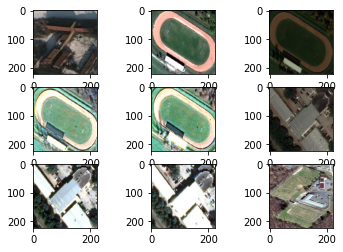

In [ ]:
# create a grid of 3*3 images to visualize some of the imgaes in dataset
for i in range(0, 9):
    plt.subplot(330 + 1+ i)
    img = test_set[0][0][i]
    plt.imshow(img)
    
# show the plot
plt.show()

## Reload Previously Trained Model

---



In [ ]:
#Enable Google SDK access to your Google Drive to pull in trained models
# Follow prompt in the authorization process

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Reload previously trained model
# Enter the path and filename for the trained model here

#export_path_keras = '/content/drive/My Drive/Colab Notebooks/Thesis Resources/Training_Sessions/trained_models/1594419823_Combine_oil_gas_fac4_epochs_h5_model.h5'
#export_path_keras = '/content/drive/My Drive/Colab Notebooks/Thesis Resources/Training_Sessions/trained_models/1594413959_Combine_oil_gas_fac_30_epochs_h5_model.h5'
#export_path_keras = '/content/drive/My Drive/Colab Notebooks/Thesis Resources/Training_Sessions/trained_models/1594421785_Combine_oil_gas_fac_35_epoch_h5_model.h5'
#export_path_keras = '/content/drive/My Drive/Colab Notebooks/Thesis Resources/Training_Sessions/trained_models/1594421120_Combine_oil_gas_fac40_epoch_h5_model.h5'

export_path_keras = '/content/drive/My Drive/Colab Notebooks/Thesis Resources/Training_Sessions/trained_models/1594426460_Combine_tunnel_4_epoch_h5_model.h5'
#export_path_keras = '/content/drive/My Drive/Colab Notebooks/Thesis Resources/Training_Sessions/trained_models/1594422010_Combine_tunnel_30_epoch_h5_model.h5'
#export_path_keras = '/content/drive/My Drive/Colab Notebooks/Thesis Resources/Training_Sessions/trained_models/1594423430_Combine_tunnel_35_epoch_h5_model.h5'
#export_path_keras = '/content/drive/My Drive/Colab Notebooks/Thesis Resources/Training_Sessions/trained_models/1594424503_Combine_tunnel_40_epoch_h5_model.h5'

#export_path_keras = '/content/drive/My Drive/Colab Notebooks/Thesis Resources/Training_Sessions/trained_models/1594425002_Combined_helo_4_Epoch_h5_model.h5'
#export_path_keras = '/content/drive/My Drive/Colab Notebooks/Thesis Resources/Training_Sessions/trained_models/1594425319_Combined_helo_30_Epoch_h5_model.h5'
#export_path_keras = '/content/drive/My Drive/Colab Notebooks/Thesis Resources/Training_Sessions/trained_models/1594424719_Combined_helo_35_epoch_h5_model.h5'
#export_path_keras = '/content/drive/My Drive/Colab Notebooks/Thesis Resources/Training_Sessions/trained_models/1594424503_Combine_tunnel_40_epoch_h5_model.h5'

# Copy trained model to local instance
export_path_keras = shutil.copyfile(export_path_keras, os.path.join('/content/' + export_path_keras.split('/')[-1]))
print(export_path_keras)

/content/1594421120_Combine_oil_gas_fac40_epoch_h5_model.h5


In [ ]:
reloaded = tf.keras.models.load_model(
  export_path_keras, 
  # `custom_objects` tells keras how to load a `hub.KerasLayer`
  custom_objects={'KerasLayer': hub.KerasLayer})

reloaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23588821  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,592,919
Trainable params: 4,098
Non-trainable params: 23,588,821
_________________________________________________________________


## Run Predictions on Test Set

---



In [ ]:
# Run predictions on entire test set
result = reloaded.predict(test_set)
result = np.argmax(result, axis=-1)
result = result.tolist()

In [ ]:
# Generate test data labels to compare to predictions
labels = []

for path in test_files:
  label = path.split('/')[-2]
  if label == test_files[0].split('/')[-2]:
    label_class = 0
  else:
    label_class = 1
  labels.append(label_class)

print(f'Labels: {labels}')
print(f'Predictions: {result}')

# Extract classes from directory names for labelling predictions below
# using .class_indices
classes_dict = test_set.class_indices
print(f'\nclasses_dict = {classes_dict}')
classes_list = list(classes_dict)
print(f'\nclasses_list: {classes_list}')

Labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## MCC Calculation

---






[Check this article for MCC description](https://towardsdatascience.com/the-best-classification-metric-youve-never-heard-of-the-matthews-correlation-coefficient-3bf50a2f3e9a)

In [ ]:
# Run the Confusion Matrix method and store values
matrix = confusion_matrix(labels, result)
#print(f'Confustion Matrix\n {matrix}\n')

# Extract values from Confusion Matrix and print Confusion Matrix
TP = matrix[0][0]
TN = matrix[1][1]
FP = matrix[0][1]
FN = matrix[1][0]
print(f'{classes_list[0]} | {classes_list[1]}')
print('='*20)
print(f'TP: {TP} | FP: {FP}')
print(f'FN: {FN}  | TN: {TN}')

# Print MCC
MCC = round(matthews_corrcoef(labels, result), 3)
print('-'*20)
print(f'\nMCC: {MCC}\n')

# Calculate Classifier accruacy metric for the target class
class_acc = round((TP + TN)/(TP + FP + FN + TN), 3)*100
print('-'*25)
print(f'Classifier Accuracy:  {class_acc}%')

# Calculate accruacy metric for the target class
tgt_class_acc = round(((TP/(FN+TP))*100),1)
# Calculate accruacy metric for the non_target class
non_tgt_class_acc = round((TP/(TN+FP)*100), 1)
# Calculate average accuracy between both tgt sets (This is different from Classifier accuracy)
# Difference between this metric and the Classifier accruracy will indicate class imbalance 
# It is only meant as a reference
avg_acc = round((tgt_class_acc + non_tgt_class_acc)/2, 3)
print(f'{classes_list[0]} accuracy: {tgt_class_acc}%')
print(f'{classes_list[1]} accuracy: {non_tgt_class_acc}%')
print(f'Average accuracy:     {avg_acc}%')

tst_non_tgt | tst_oil_gas_fac
TP: 566 | FP: 50
FN: 328  | TN: 538
--------------------

MCC: 0.544

-------------------------
Classifier Accuracy:  74.5%
tst_non_tgt accuracy: 63.3%
tst_oil_gas_fac accuracy: 96.3%
Average accuracy:     79.8%


![alt text](https://miro.medium.com/max/1400/1*8E2rPn_ccOqGuPYj1gBTAg.png
)